# Active regression
In this example, we are going to demonstrate how can the ActiveLearner be used for active regression using Gaussian processes. Since Gaussian processes provide a way to quantify uncertainty of the predictions as the covariance function of the process, they can be used in an active learning setting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

%matplotlib inline

## The dataset
For this example, we shall try to learn the *noisy sine* function:

In [2]:
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

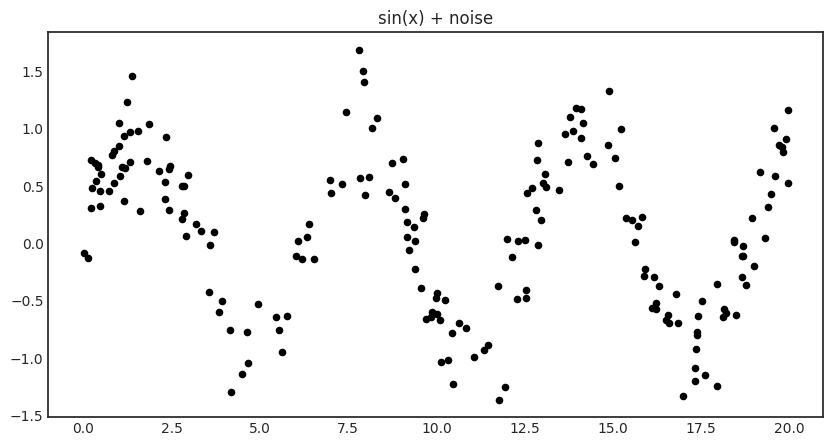

In [4]:
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', s=20)
    plt.title('sin(x) + noise')
    plt.show()

## Uncertainty measure and query strategy for Gaussian processes
For active learning, we shall define a custom query strategy tailored to Gaussian processes. More information on how to write your custom query strategies can be found at the page [Extending modAL](https://cosmic-cortex.github.io/modAL/Extending-modAL). In a nutshell, a *query stategy* in modAL is a function taking (at least) two arguments (an estimator object and a pool of examples), outputting the index of the queried instance. In our case, the arguments are ```regressor``` and ```X```.

In [5]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

## Active learning
Initializing the active learner is as simple as always.

In [6]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

/mnt/e/Github/TricksAndTips/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


The initial regressor is not very accurate.

In [7]:
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

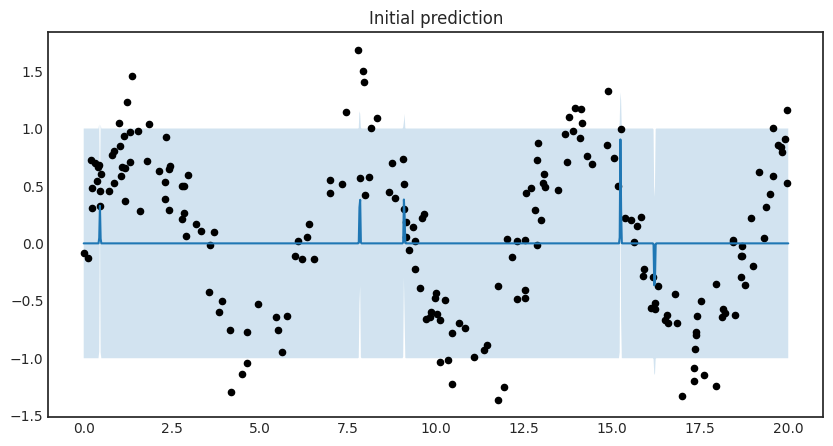

In [9]:
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()

The blue band enveloping the regressor represents the standard deviation of the Gaussian process at the given point. Now we are ready to do active learning!

In [10]:
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

/mnt/e/Github/TricksAndTips/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [11]:
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

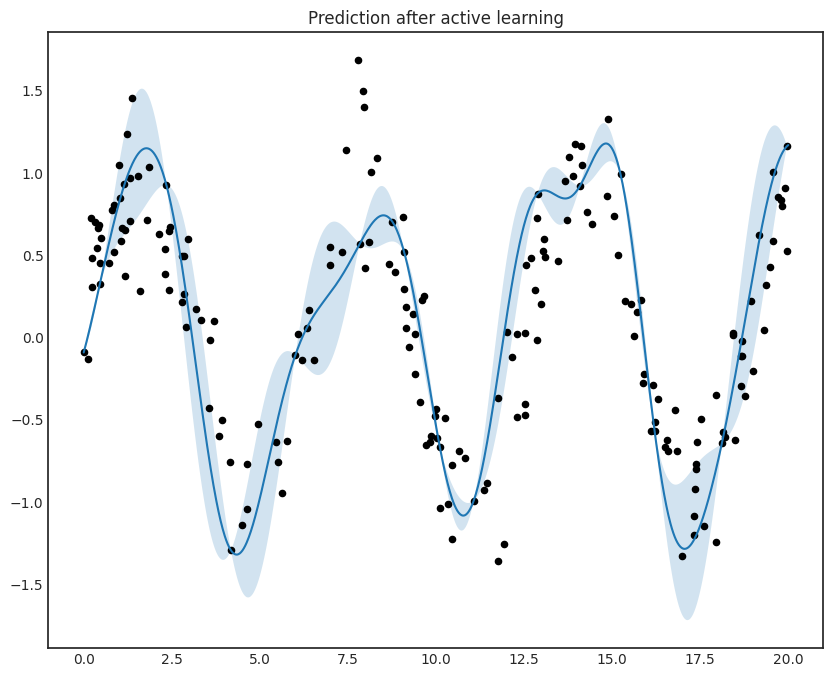

In [13]:
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()